In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine,reflect=True)

In [5]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
station = base.classes.station
measurement = base.classes.measurement
print(measurement)

<class 'sqlalchemy.ext.automap.measurement'>


In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [9]:
columns = inspector.get_columns('measurement')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [10]:
columns = inspector.get_columns('station')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


# Exploratory Climate Analysis

<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 2016-08-23 to 2017-08-23
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precipitation  366 non-null    float64
dtypes: float64(1)
memory usage: 5.7+ KB


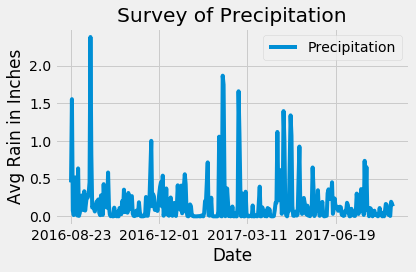

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lateststr = session.query(measurement.date).order_by(measurement.date.desc()).first()
latestdate = dt.datetime.strptime(lateststr[0], '%Y-%m-%d')


#print(f"Latest: {lateststr[0]}")
# Calculate the date 1 year ago from the last data point in the database
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

# Perform a query to retrieve the data and precipitation scores
sel_rain = [measurement.date,measurement.prcp]
last12_rain = session.query(*sel_rain).filter(measurement.date >= querydate).all()
last12_rain

# Save the query results as a Pandas DataFrame and set the index to the date column
precip = pd.DataFrame(last12_rain, columns=['Date', 'Precipitation'])
precip = precip.dropna(how='any')
# precip_group = precip_group.mean()
# precip_group = precip_group.drop_duplicates()

# Sort the dataframe by date

precip_group = precip.sort_values(["Date"], ascending=True)
precip_group = precip.set_index("Date")
precip_group = precip_group.groupby(["Date"]).mean()

precip_group.info()

# Use Pandas Plotting with Matplotlib to plot the data
precip_group.plot()
# plt.bar(x_axis, precip_group["Precipitation"], color='b', align="center", label='Precipitation')
plt.xlabel("Date")
plt.ylabel("Avg Rain in Inches")
plt.title("Survey of Precipitation")
plt.tight_layout()



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# max_rain = precip_group.max()
# min_rain = precip.min()
# avg_rain = precip.mean()
# max_rain
precip.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(station.name).count()
station_count

9

In [129]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# sel = [measurement.station,func.count(measurement.id)]
active_stations = session.query(measurement.station,
                                func.count(measurement.station).\
                                label('count')).group_by(measurement.station).\
order_by(func.count(measurement.id).desc()).limit(1)[0][0]
active_stations
# most_active = pd.DataFrame(active_stations).max()
# most_active

'USC00519281'

In [130]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# temp = session.query(measurement.station,
#                     func.max(measurement.tobs).\
#                     func.min(measurement.tobs).\
# order_by(func.max(measurement.tobs)),(func.min(measurement.tobs)))

stations_m = session.query(measurement.station,measurement.prcp,measurement.tobs,measurement.id,measurement.date)
stations_data = pd.DataFrame(stations_m).set_index("station")

# most_active_data = pd.DataFrame(stations_data).loc["USC00519523"]
active_station_df = stations_data.loc["USC00519281"]

active_min = active_station_df["tobs"].min()
active_max = active_station_df["tobs"].max()
active_avg = active_station_df["tobs"].mean()

active_df = [active_min, active_max, active_avg]
active_df

[54.0, 85.0, 71.66378066378067]

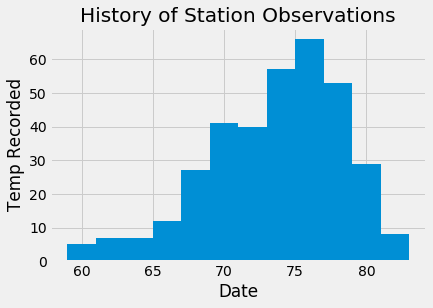

In [139]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_temp = session.query(measurement.tobs).filter(measurement.station== active_stations).filter(measurement.date >= querydate).order_by(measurement.date.desc()).all()

temp_obs_df = pd.DataFrame(active_temp)
temp_obs_df

plt.hist(temp_obs_df['tobs'], bins=12)
plt.xlabel("Date")
plt.ylabel("Temp Recorded")
plt.title("History of Station Observations")

plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
